In [86]:
%load_ext autoreload
%autoreload 2

import os
import src.starter.utils as starter
import src.starter.visualize as vis
import src.starter.visualize2 as vis2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook, tqdm
import numpy as np
import matplotlib as mpl
from src.vis_utils import multi_slice_viewer, find_first_kidney_slice
tqdm.pandas()

from src.utils import load_checkpoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create h5 files

In [87]:
import h5py
import src.starter.utils as starter
import src.starter.visualize as vis
import pandas as pd
import numpy as np

In [88]:
data = pd.read_csv("data_interpolated_stats.csv")

max_val = data['max_val'].quantile(0.95)
min_val = data['min_val'].quantile(0.01)

print(max_val)
print(min_val)

3520.071521822407
-3481.5497069856415


In [91]:
D_SIZE, H_SIZE, W_SIZE = 32, 128, 128
D_STRIDE, H_STRIDE, W_STRIDE = 16, 64, 64
crop_config = "{}_{}_{}".format(H_SIZE, W_SIZE, D_SIZE)
WINDOW = (D_SIZE, H_SIZE, W_SIZE)
STRIDE = (D_STRIDE, H_STRIDE, W_STRIDE)

# stage = "train"
stage = "val"


data = pd.read_csv("{}_data_interpolated_stats.csv".format(stage))
cropsfile = h5py.File("data_ready/{}_{}.hdf5".format(stage, crop_config), "w")
cropscsv = "data_ready/{}_{}.csv".format(stage, crop_config)

In [92]:
def normalize(volume, min_val, max_val):
    im_volume = (volume - min_val) / max(max_val - min_val, 1e-3)
    return im_volume

def positions(im_shape, crop_shape, strides):
        zi, xi, yi = im_shape
        zc, xc, yc = crop_shape
        zs, xs, ys = strides
        for z in [z for z in range(0, zi, zs) if z + zc <= zi]:
            for x in [x for x in range(0, xi, xs) if x + xc <= xi]:
                for y in [y for y in range(0, yi, ys) if y + yc <= yi]:
                    yield (z, x, y)
                    
def get_pad_size(imsize, cropsize):
    if imsize % cropsize == 0:
        return 0
    else:
        return cropsize - imsize % cropsize
    
def halved_pads(pad_size):
    return (pad_size//2, pad_size//2 + pad_size%2)

In [93]:
crops_data = []
for i in tqdm_notebook(range(len(data))):
    row = data.iloc[i]
    case_id, z, x, y = row['case_id'], row['num_slices'], row['height'], row['width']
    im, mask = starter.load_case(case_id)
    im, mask = im.get_data(), mask.get_data()
    print("Before padding:", im.shape)
    
    z_pad_size = get_pad_size(im.shape[0], D_SIZE)
    y_pad_size = get_pad_size(im.shape[1], H_SIZE)
    x_pad_size = get_pad_size(im.shape[2], W_SIZE)
        
    im = normalize(im, min_val, max_val)
    im = np.pad(im, (halved_pads(z_pad_size),
                     halved_pads(y_pad_size),
                     halved_pads(x_pad_size)), 'constant')
    mask = np.pad(mask, (halved_pads(z_pad_size),
                         halved_pads(y_pad_size),
                         halved_pads(x_pad_size)), 'constant')
    print("After padding:", im.shape)
    for position in positions((int(z + z_pad_size), int(y + y_pad_size), int(x + x_pad_size)),
                              WINDOW, STRIDE):
        z, y, x = position
        cropped_mask = mask[z:z+D_SIZE, y:y+H_SIZE, x:x+W_SIZE]
        kid_size = np.sum(cropped_mask == 1)
        tumor_size = np.sum(cropped_mask == 2)
        crops_data.append([case_id, position, WINDOW, STRIDE, kid_size, tumor_size])
    cropsfile.create_dataset(case_id, data=np.array([im, mask]))

Before padding: (153, 584, 584)
After padding: (160, 640, 640)
Before padding: (69, 434, 434)
After padding: (96, 512, 512)
Before padding: (63, 383, 383)
After padding: (64, 384, 384)
Before padding: (113, 483, 483)
After padding: (128, 512, 512)
Before padding: (63, 538, 538)
After padding: (64, 640, 640)
Before padding: (119, 501, 501)
After padding: (128, 512, 512)
Before padding: (98, 460, 460)
After padding: (128, 512, 512)
Before padding: (48, 639, 639)
After padding: (64, 640, 640)
Before padding: (164, 639, 639)
After padding: (192, 640, 640)
Before padding: (175, 463, 463)
After padding: (192, 512, 512)
Before padding: (54, 460, 460)
After padding: (64, 512, 512)
Before padding: (85, 482, 482)
After padding: (96, 512, 512)
Before padding: (80, 482, 482)
After padding: (96, 512, 512)
Before padding: (86, 639, 639)
After padding: (96, 640, 640)
Before padding: (98, 570, 570)
After padding: (128, 640, 640)
Before padding: (190, 511, 511)
After padding: (192, 512, 512)
Before pad

In [94]:
cropsfile.close()

In [95]:
crops_data = pd.DataFrame(data=crops_data,
                          columns=["case_id", "position", "window_size",
                                   "stride", "kid_size", "tumor_size"])
crops_data.to_csv(cropscsv)
crops_data.head()

,case_id,position,window_size,stride,kid_size,tumor_size
0,case_00105,"(0, 0, 0)","(32, 128, 128)","(16, 64, 64)",0,0
1,case_00105,"(0, 0, 64)","(32, 128, 128)","(16, 64, 64)",0,0
2,case_00105,"(0, 0, 128)","(32, 128, 128)","(16, 64, 64)",0,0
3,case_00105,"(0, 0, 192)","(32, 128, 128)","(16, 64, 64)",0,0
4,case_00105,"(0, 0, 256)","(32, 128, 128)","(16, 64, 64)",0,0


In [71]:
# data.crops
pd.read_csv("train_interpolated_crops.csv").head()

,Unnamed: 0,case_id,position,window,padding,kid_size,tumor_size
0,0,case_00140,"(0, 0, 0)",64,32,0,0
1,1,case_00140,"(0, 0, 32)",64,32,0,0
2,2,case_00140,"(0, 0, 64)",64,32,0,0
3,3,case_00140,"(0, 0, 96)",64,32,0,0
4,4,case_00140,"(0, 0, 128)",64,32,0,0


In [44]:
spacing = np.array([[ 0.        ,  0.        , -0.78162497,  0.        ],
                    [ 0.        , -0.78162497,  0.        ,  0.        ],
                    [-3.        ,  0.        ,  0.        ,  0.        ],
                    [ 0.        ,  0.        ,  0.        ,  1.        ]])

spc_ratio = np.abs(np.sum(spacing[2,:]))/np.abs(np.sum(spacing[0,:]))
64 / spc_ratio

16.674666026666667

In [96]:
import torch
import torch.utils.data
import pandas as pd
import h5py

from src.config import config
from src.data import H5CropData2
from src.train import Trainer
from src.unet import UNet3D
from src.unet_dsv import unet_CT_multi_att_dsv_3D, unet_grid_attention_3D
from src.utils import load_checkpoint

import matplotlib as mpl
import src.starter.visualize2 as vis2
from src.vis_utils import multi_slice_viewer, find_first_kidney_slice

In [97]:
data = H5CropData2("data_ready/train_128_128_32.hdf5", "data_ready/train_128_128_32.csv")
train_loader = torch.utils.data.DataLoader(data, batch_size=1, num_workers=16, shuffle=True)

tensor(0.) tensor(0.5082)
torch.Size([1, 1, 32, 128, 128])
torch.Size([1, 32, 128, 128])
tensor(0)


<IPython.core.display.Javascript object>


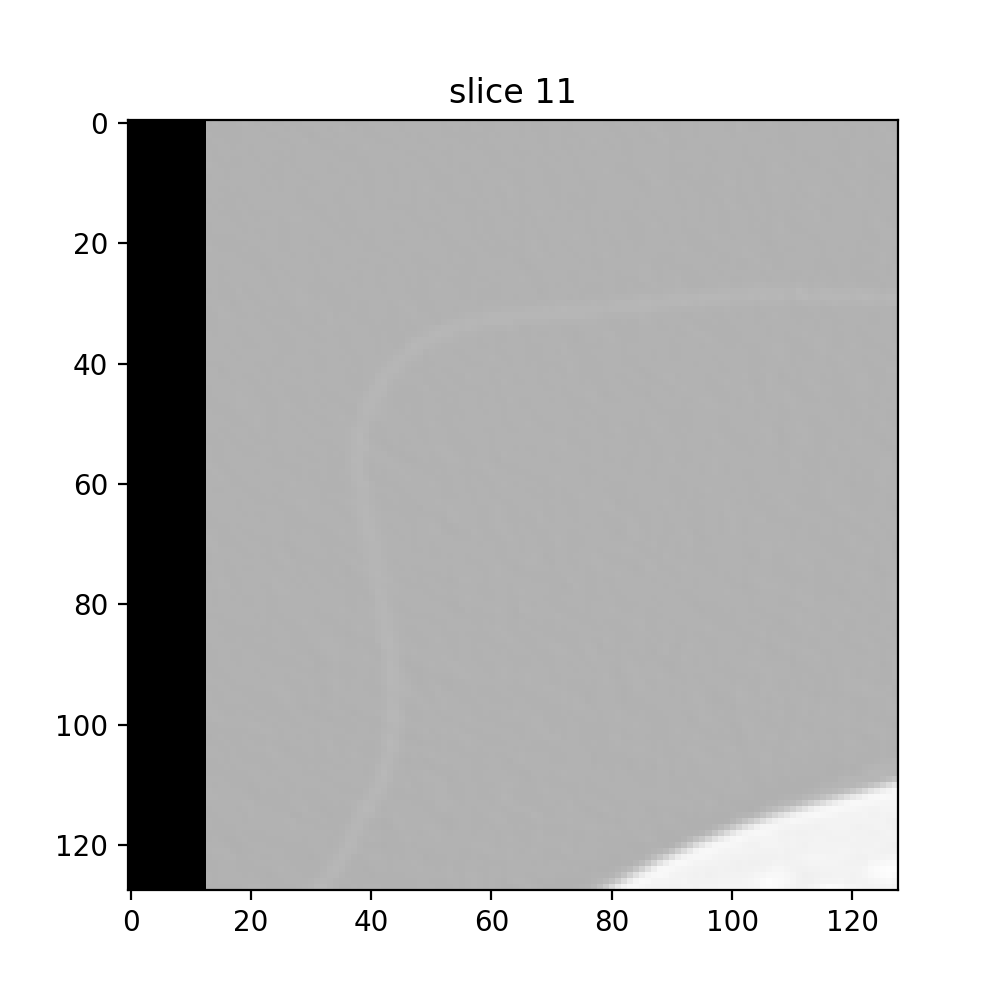

In [98]:
for im, mask in train_loader:
    print(im.min(), im.max())
    break

print(im.shape)   # (N, C, D, H, W)
print(mask.shape) # (N, D, H, W)
print(mask.sum())

%matplotlib notebook
mpl.rcParams['figure.figsize'] = (5,5)
overlayed = vis2.overlayed_images(im[0,0].numpy(), mask[0].numpy(), plane='axial')
multi_slice_viewer(overlayed, cmap='gray')